In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import numpy as np
import scanpy.api as sc
from anndata import read_h5ad
from anndata import AnnData
import scipy as sp
import re
from adjustText import adjust_text
import time
from statsmodels.stats.multitest import multipletests
# Other specific functions 
from itertools import product
from statsmodels.stats.multitest import multipletests

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

/home/martin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


scanpy==1.4.3 anndata==0.6.20 umap==0.3.8 numpy==1.16.4 scipy==1.2.1 pandas==0.25.0 scikit-learn==0.21.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


# Overview

In this notebook, we provide a self-contained example of the diversity score analysis as presented in the [**Tabula Muris Senis**](https://www.biorxiv.org/content/10.1101/661728v2) paper (Figure 4). Specifically, we performed a tissue-level diversity score analysis of two tissues, Brain_Myeloid and Marrow: 

1. Cluster cells from each mouse-tissue pair
2. Assgin a diversity score for each mouse-tissue pair. 
3. Assign a p-value to the two tissues quantifying how much the diversity change over time, with visualization similar to Figure 4c and Supplementaru Figure 11a-b
4. Exact UMAP visualization of Figure 4d

This notebook only covers the tissue-level analysis. Tissue-cell level analysis is similar and hence is not shown here. 

## 1. Load data
Here we consider the FACS brain_myeloid and marrow data from all mice, stored as `facs_brain_myeloid_normalized.h5ad`. The data has already gone through 

1. Size factor normalization (to have 1e4 reads per cell)
2. $\log(x+1)$ transform.

The data can be downloaded at [link](https://figshare.com/articles/Diversity_score_toy_data/11340128) (250MB). Please specify the `data_path` directory to be your local path containing the data `facs_demo_normalized.h5ad`. 

In [16]:
data_path = '/data3/martin/tms_diversity_score_demo_data'
adata = read_h5ad(f'{data_path}/facs_demo_normalized.h5ad')
adata.obs.groupby('tissue').agg({'cell':len})

,cell
tissue,
Brain_Myeloid,13576
Marrow,14518


## 2. Clustering cells from each mouse-tissue pair
This section corresponds to the procedures in `cluster_mouse_tissue.ipynb`

### 2.1 Generate a list of all mouse-tissue pairs `analysis_list`. 
A mouse-tissue pair is included if it contains more than 100 cells.

In [3]:
# tissue list and mouse_id list
tissue_list = list(set(adata.obs['tissue']))
mouse_id_list = list(set(adata.obs['mouse.id']))
# analysis_list
analysis_list = []
for tissue in tissue_list:
    for mouse_id in mouse_id_list:
        ind_select = (adata.obs['tissue'] == tissue) & (adata.obs['mouse.id'] == mouse_id)
        if ind_select.sum()>100:
            analysis_list.append('%s.%s'%(mouse_id,tissue))
            print('%s.%s,'%(mouse_id,tissue), '%d cells'%ind_select.sum())
print(analysis_list)

3_39_F.Marrow, 770 cells
18_53_M.Marrow, 1221 cells
18_45_M.Marrow, 1012 cells
3_9_M.Marrow, 1006 cells
24_58_M.Marrow, 1100 cells
24_61_M.Marrow, 1202 cells
3_38_F.Marrow, 879 cells
3_8_M.Marrow, 1164 cells
18_46_F.Marrow, 1281 cells
24_60_M.Marrow, 1163 cells
24_59_M.Marrow, 1200 cells
3_10_M.Marrow, 1250 cells
18_47_F.Marrow, 1270 cells
3_39_F.Brain_Myeloid, 852 cells
18_53_M.Brain_Myeloid, 782 cells
18_45_M.Brain_Myeloid, 1227 cells
3_9_M.Brain_Myeloid, 678 cells
24_58_M.Brain_Myeloid, 1253 cells
24_61_M.Brain_Myeloid, 1060 cells
3_38_F.Brain_Myeloid, 1102 cells
3_8_M.Brain_Myeloid, 587 cells
18_46_F.Brain_Myeloid, 1242 cells
24_60_M.Brain_Myeloid, 1195 cells
3_56_F.Brain_Myeloid, 294 cells
24_59_M.Brain_Myeloid, 1075 cells
3_10_M.Brain_Myeloid, 1019 cells
18_47_F.Brain_Myeloid, 1210 cells
['3_39_F.Marrow', '18_53_M.Marrow', '18_45_M.Marrow', '3_9_M.Marrow', '24_58_M.Marrow', '24_61_M.Marrow', '3_38_F.Marrow', '3_8_M.Marrow', '18_46_F.Marrow', '24_60_M.Marrow', '24_59_M.Marrow', '3

### 2.2 Define the clustering algorithm

In [4]:
def cluster_algorithm(input_adata, resolution_val=.7):
    adata = input_adata.copy()
    sc.pp.highly_variable_genes(adata, subset = False, min_disp=.5,
                                max_disp=None, min_mean=.0125, max_mean=10,
                                n_bins=20, n_top_genes=None)
    sc.pp.scale(adata, max_value=10, zero_center=False)
    sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
    sc.tl.louvain(adata, resolution = resolution_val)
    sc.tl.leiden(adata, resolution = resolution_val)
    return adata

### 2.3 Cluster all cells in each mouse-tissue

The clustering is done with: 

- two clustering methods (louvain, leiden) $\times$ three resolutions (0.3, 0.5, 0.7).

All together 6 different combinations. This may take a while, *~10mins* as shown below. However my CPUs are outdated. It may be faster on your computer.

In [5]:
start_time = time.time()
dic_data_03 = {}
dic_data_05 = {}
dic_data_07 = {}
for analyte in analysis_list:
    print('mouse-tissue:%s, time=%0.1fs'%(analyte, time.time()-start_time))
    mouse_id,tissue = analyte.split('.')
    ind_select = (adata.obs['tissue'] == tissue) & (adata.obs['mouse.id'] == mouse_id)
    temp_adata = adata[ind_select]
    dic_data_03[analyte] = cluster_algorithm(temp_adata, resolution_val=0.3)
    dic_data_05[analyte] = cluster_algorithm(temp_adata, resolution_val=0.5)
    dic_data_07[analyte] = cluster_algorithm(temp_adata, resolution_val=0.7)
print('clustering finished, time=%0.1fs'%(time.time()-start_time))

mouse-tissue:3_39_F.Marrow, time=0.0s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:18_53_M.Marrow, time=30.4s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:18_45_M.Marrow, time=51.7s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:3_9_M.Marrow, time=74.5s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:24_58_M.Marrow, time=96.0s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:24_61_M.Marrow, time=114.1s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:3_38_F.Marrow, time=138.8s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:3_8_M.Marrow, time=161.6s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:18_46_F.Marrow, time=186.6s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:24_60_M.Marrow, time=209.7s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:24_59_M.Marrow, time=237.5s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:3_10_M.Marrow, time=263.6s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:18_47_F.Marrow, time=290.2s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:3_39_F.Brain_Myeloid, time=313.6s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:18_53_M.Brain_Myeloid, time=336.2s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:18_45_M.Brain_Myeloid, time=352.7s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:3_9_M.Brain_Myeloid, time=381.3s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:24_58_M.Brain_Myeloid, time=398.6s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:24_61_M.Brain_Myeloid, time=429.1s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:3_38_F.Brain_Myeloid, time=450.0s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:3_8_M.Brain_Myeloid, time=479.2s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:18_46_F.Brain_Myeloid, time=496.2s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:24_60_M.Brain_Myeloid, time=524.3s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:3_56_F.Brain_Myeloid, time=554.6s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:24_59_M.Brain_Myeloid, time=565.2s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:3_10_M.Brain_Myeloid, time=588.4s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


mouse-tissue:18_47_F.Brain_Myeloid, time=617.0s


/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)
/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


clustering finished, time=644.9s


## 3. Downstream analysis
From last section, we have clustered all mouse-tissue pairs and the results are stored in `dic_data_03`, `dic_data_05`, `dic_data_07` for the three different resolutions. We now preceed to the following downstream analysis.

1. Compute a diversity score for each mouse-tissue pair
2. Assign a p-values for each tissue based on linear regression on all mouse-tissue pairs from that tissue
3. Draw the nice UMAP annotation figure

This section corresponds to the procedures in `cluster_mouse_tissue_downstream.ipynb`

### 3.1 Some basic annotations

In [6]:
# mice annotation
df_annotation = pd.DataFrame(index=mouse_id_list)
df_annotation['age'] = ['%sm'%re.split('_|-', x)[0] for x in df_annotation.index]
df_annotation['age_num'] = [int(re.split('_|-', x)[0]) for x in df_annotation.index]
df_annotation['sex'] = ['male' if 'M' in x else 'female' for x in df_annotation.index]
print('df_annotation')
print(df_annotation)
print('')
# A sorted age list
age_list = list(set(df_annotation['age_num']))
age_list.sort()
age_list = ['%sm'%x for x in age_list]
print('age_list')
print(age_list)
print('')
# Another list with only old and young
age_yo_list = ['young', 'old']
print('age_yo_list')
print(age_yo_list)
print('')
# The list of all clustering algorithm configurations
cluster_config_list = ['03.louvain', '03.leiden', '05.louvain', '05.leiden',
                       '07.louvain', '07.leiden']
print('cluster_config_list')
print(cluster_config_list)
print('')

df_annotation
         age  age_num     sex
3_39_F    3m        3  female
18_53_M  18m       18    male
18_45_M  18m       18    male
3_9_M     3m        3    male
24_58_M  24m       24    male
24_61_M  24m       24    male
3_38_F    3m        3  female
3_8_M     3m        3    male
18_46_F  18m       18  female
24_60_M  24m       24    male
3_56_F    3m        3  female
24_59_M  24m       24    male
3_10_M    3m        3    male
18_47_F  18m       18  female

age_list
['3m', '18m', '24m']

age_yo_list
['young', 'old']

cluster_config_list
['03.louvain', '03.leiden', '05.louvain', '05.leiden', '07.louvain', '07.leiden']



### 3.2 Compute diversity score
- Here we compute diversity score for each clustering configuration and each mouse-tissue pair
- The data is stored in a dictionary `dic_diversity_score` 

In [17]:
# A dictionary to store the diversity scores
dic_diversity_score = {x:pd.DataFrame(index = mouse_id_list, columns=tissue_list, data=-1)
                       for x in cluster_config_list}
# Iterate over all clustering configurations 
for cluster_config in cluster_config_list:
    # Corresponding clustering result
    if cluster_config.split('.')[0] == '03':
        temp_dic_data = dic_data_03.copy()
    elif cluster_config.split('.')[0] == '05':
        temp_dic_data = dic_data_05.copy()
    elif cluster_config.split('.')[0] == '07':
        temp_dic_data = dic_data_07.copy()
    # Assign a diversity score for each mouse-tissue
    for analyte in analysis_list:
        mouse_id,tissue = analyte.split('.')
        temp_adata = temp_dic_data[analyte].copy()
        cluster_method = cluster_config.split('.')[1]
        # Diversity score (Shannon entropy diversity)
        pk = np.array(temp_adata.obs[cluster_method], dtype=int)
        pk = np.bincount(pk)
        dic_diversity_score[cluster_config].loc[mouse_id, tissue] = sp.stats.entropy(pk)
print('dic_diversity_score is a dictionary with keys corresponding to the six clustering configurations')
print(dic_diversity_score.keys())
print('')
print('Each item stores the diversity of all mouse-tissue pairs')
print("dic_diversity_score['03.louvain']")
print(dic_diversity_score['03.louvain'])

dic_diversity_score is a dictionary with keys corresponding to the six clustering configurations
dict_keys(['03.louvain', '03.leiden', '05.louvain', '05.leiden', '07.louvain', '07.leiden'])

Each item stores the diversity of all mouse-tissue pairs
dic_diversity_score['03.louvain']
           Marrow  Brain_Myeloid
3_39_F   1.962723       0.000000
18_53_M  1.699812       0.692594
18_45_M  1.236267       0.619511
3_9_M    1.713163       0.842528
24_58_M  1.696537       0.791293
24_61_M  1.530937       0.964393
3_38_F   1.747574       0.000000
3_8_M    1.979944       0.000000
18_46_F  1.275950       0.739137
24_60_M  1.525056       1.189845
3_56_F  -1.000000       0.000000
24_59_M  1.678234       0.802261
3_10_M   1.556897       0.247684
18_47_F  1.796384       0.691173


### 3.3 Compute a p-value for each tissue and each configurations

Here we use a DataFrame `df_analysis_tissue` to store the results for each tissue:

- raw-p (from linear regression)
- bh-p (from FDR control)
- slope (from linear regression)

In [9]:
# assign a p-value by LR 
df_analysis_tissue = pd.DataFrame(index=tissue_list)
for cluster_config in cluster_config_list:
    df_analysis_tissue['%s.raw_p'%cluster_config] = -1
    df_analysis_tissue['%s.bh_p'%cluster_config] = -1
    df_analysis_tissue['%s.slope'%cluster_config] = -1
    # diversity score of all mouse-tissue for cluster_config
    temp_df_div = dic_diversity_score[cluster_config].copy()
    temp_analysis_list = temp_df_div.columns
    temp_df_div = temp_df_div.join(df_annotation)
    # Iterate over all tissues and compute nominal p-value
    for analyte in temp_analysis_list:
        temp_df_LR = temp_df_div[[analyte, 'age_num']]
        temp_df_LR = temp_df_LR.loc[temp_df_LR[analyte]>-1]
        # If the tissue has <5 mice, skip because of the small sample size
        if temp_df_LR.shape[0]<5: 
            continue
        sl, icpt, r_val, p_val, _ = sp.stats.linregress(temp_df_LR['age_num'],
                                                        temp_df_LR[analyte])
        df_analysis_tissue.loc[analyte, '%s.raw_p'%cluster_config] = p_val
        df_analysis_tissue.loc[analyte, '%s.slope'%cluster_config] = sl
    # Compute bh-p value (over all tissues for the same cluster_config)
    temp_df = df_analysis_tissue[['%s.raw_p'%cluster_config]]
    temp_df = temp_df.loc[temp_df['%s.raw_p'%cluster_config]>-1]
    res_bh = multipletests(temp_df['%s.raw_p'%cluster_config], alpha=0.2, method='fdr_bh')
    temp_df['%s.bh_p'%cluster_config] = res_bh[1]
    df_analysis_tissue.loc[temp_df.index, '%s.bh_p'%cluster_config] =\
        temp_df['%s.bh_p'%cluster_config]
print(df_analysis_tissue)

               03.louvain.raw_p  03.louvain.bh_p  03.louvain.slope  \
Marrow                 0.105050         0.105050         -0.011103   
Brain_Myeloid          0.000268         0.000537          0.035397   

               03.leiden.raw_p  03.leiden.bh_p  03.leiden.slope  \
Marrow                0.044113        0.044113        -0.021865   
Brain_Myeloid         0.006915        0.013829         0.029845   

               05.louvain.raw_p  05.louvain.bh_p  05.louvain.slope  \
Marrow                 0.014414         0.014414         -0.013741   
Brain_Myeloid          0.001863         0.003726          0.030149   

               05.leiden.raw_p  05.leiden.bh_p  05.leiden.slope  \
Marrow                0.007002        0.007002        -0.020678   
Brain_Myeloid         0.000199        0.000398         0.038249   

               07.louvain.raw_p  07.louvain.bh_p  07.louvain.slope  \
Marrow                 0.093308         0.093308         -0.009741   
Brain_Myeloid          0.005920   

### 3.4 Visulizations 

1. Heapmap of diveristy change (over age) for each tissue and each clustering configuration
2. Diversity score of every mouse for each tissue and each clustering configuration

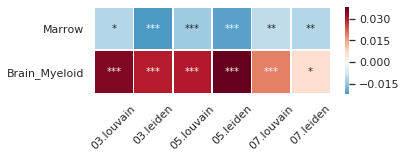

In [10]:
def assign_star(x):
    if (x<0.05):
        return '***'
    elif (x<0.1):
        return '**'
    elif (x<0.2):
        return '*'
    else:
        return ''
    
bh_p_list = ['%s.bh_p'%x for x in cluster_config_list]
slope_list = ['%s.slope'%x for x in cluster_config_list]
# Heatmap
plot_df = df_analysis_tissue[slope_list+bh_p_list]
ind_sort = np.argsort(plot_df[slope_list].mean(axis=1))
plot_df = plot_df.iloc[ind_sort]
# Convert bh_p_list to star_list
star_list = ['%s.star'%x for x in cluster_config_list]
for cluster_config in cluster_config_list:
    plot_df['%s.star'%cluster_config] = [assign_star(x)
                                         for x in plot_df['%s.bh_p'%cluster_config]]
# add marker for significant ones
plt.figure(figsize=[6,2.5])
sns.heatmap(plot_df[slope_list], cmap = 'RdBu_r', center=0,
            annot=plot_df[star_list], fmt="s", linewidths=.5)
plt.xticks(np.arange(len(slope_list))+0.5, [x.replace('.slope', '') for x in slope_list],
           rotation=45)
plt.yticks(np.arange(plot_df.shape[0])+0.5, plot_df.index, rotation=0)
plt.tight_layout(rect=[0, 0.03, 0.95, 0.95])
plt.show()

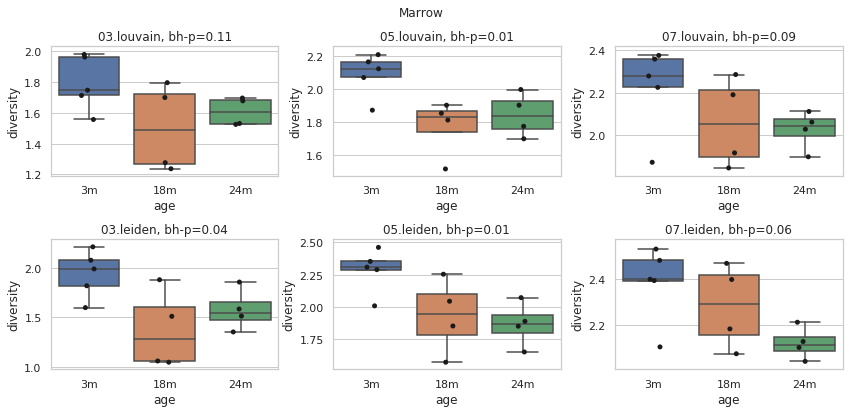

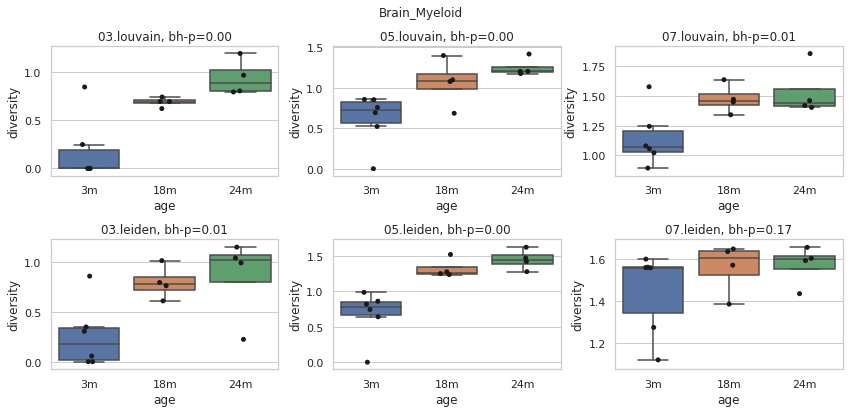

In [11]:
temp_cluster_config_list = ['03.louvain', '05.louvain', '07.louvain',
                            '03.leiden', '05.leiden', '07.leiden']
for analyte in df_analysis_tissue.index:
    plt.figure(figsize=[12,6])
    i_pic = 0
    for cluster_config in temp_cluster_config_list:
        i_pic += 1
        plt.subplot(2,3,i_pic)
        temp_div = dic_diversity_score[cluster_config].copy()
        temp_div = temp_div.join(df_annotation)
        temp_div = temp_div.loc[temp_div[analyte]>-1,[analyte, 'age']]
        # plot figures
        sns.stripplot(y=analyte, x='age', data=temp_div, order = age_list, color='k')
        sns.boxplot(y=analyte, x='age', data=temp_div, order = age_list, fliersize=0)
        plt.ylabel('diversity')
        plt.title('%s, bh-p=%0.2f'%(cluster_config, df_analysis_tissue.loc[analyte, '%s.bh_p'%cluster_config]))
    plt.suptitle(analyte)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### 3.5 UMAP plot for Brain_Myeloid


In [12]:
def cluster_algorithm_umap(input_adata, resolution_val=.7):
    adata = input_adata.copy()
    sc.pp.highly_variable_genes(adata, subset = False, min_disp=.5,
                                max_disp=None, min_mean=.0125, max_mean=10,
                                n_bins=20, n_top_genes=None)
    sc.pp.scale(adata, max_value=10, zero_center=False)
    sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
    sc.tl.leiden(adata, resolution = resolution_val)
    sc.tl.umap(adata)
    return adata

# Cluster again using Leidan and 0.7
ind_select = (adata.obs['tissue'] == 'Brain_Myeloid')
temp_data = adata[ind_select]
temp_data = cluster_algorithm_umap(temp_data)

/home/martin/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1123: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


In [13]:
# Some helper functions to parse the clustering result into age compositions 
def parse_cluster_result(input_data):
    """Parse the cell composition of clusters based on some other annotations 

    Args:
        input_data (adata, with clustering result): input clustered data 
        ref_list (list): list of annotations to match the cluster result with

    Returns:
        df_cluster_annotation (df): parsed clustering result
    """
    temp_adata = input_data.copy()
    temp_adata.obs['age_yo'] = ['young' if x in ['1m', '3m'] else 'old'
                                for x in temp_adata.obs['age']]
    # A sorted age list
    age_list = [int(x[:-1])for x in set(temp_adata.obs['age'])]
    age_list.sort()
    age_list = ['%dm'%x for x in age_list]
    # Cluster list 
    cluster_list = [str(x) for x in
                    np.sort(np.array(list(set(temp_adata.obs['leiden'])), dtype=int))]
    # Build cluster annotation
    df_cluster_annotation = pd.DataFrame(index=cluster_list)
    df_cluster_annotation['cluster_size'] = [np.sum(temp_adata.obs['leiden']==x)
                                             for x in cluster_list]
    # Add count for each age
    temp_df = compute_df_concordance(temp_adata.obs['leiden'], temp_adata.obs['age'])
    temp_df = temp_df.loc[age_list]
    temp_df.index = ['%s.ct'%x for x in age_list]
    df_cluster_annotation = df_cluster_annotation.join(temp_df.transpose())
    # Add normalized proportion for each age
    temp_df = temp_df.divide(temp_df.sum(axis=1), axis='rows')*1000
    temp_df = temp_df.divide(temp_df.sum(axis=0), axis='columns')
    temp_df.index = ['%s.prop'%x for x in age_list]
    df_cluster_annotation = df_cluster_annotation.join(temp_df.transpose())
    # Do the same for age_yo
    age_yo_list = ['young', 'old']
    temp_df = compute_df_concordance(temp_adata.obs['leiden'], temp_adata.obs['age_yo'])
    temp_df = temp_df.loc[age_yo_list]
    temp_df.index = ['%s.ct'%x for x in age_yo_list]
    df_cluster_annotation = df_cluster_annotation.join(temp_df.transpose())
    # Add normalized proportion for each age_yo
    temp_df = temp_df.divide(temp_df.sum(axis=1), axis='rows')*1000
    temp_df = temp_df.divide(temp_df.sum(axis=0), axis='columns')
    temp_df.index = ['%s.prop'%x for x in age_yo_list]
    df_cluster_annotation = df_cluster_annotation.join(temp_df.transpose())
    return df_cluster_annotation

# Compare the concordance of two sets of labels 
def compute_df_concordance(y_ref, y_query, sort_list=True):
    """Compare the concordance of two sets of labels 

    Args:
        y_ref (list/array): reference label.
        y_query (list/array): query label.

    Returns:
        df_concordance (df): concordance matrix
    """
    list_ref = list(set(y_ref))
    list_query = list(set(y_query))
    if sort_list:
        list_ref.sort()
        list_query.sort()
    df_concordance = pd.DataFrame(index = list_query, columns = list_ref, data=0) 
    for val_query,val_ref in product(list_query, list_ref):
        df_concordance.loc[val_query, val_ref] = np.sum((y_ref==val_ref) &
                                                        (y_query==val_query))
    return df_concordance

In [14]:
# Visualizing for all cases
df_cluster_annotation = parse_cluster_result(temp_data)
# UMAP coefficients for plotting
df_UMAP = temp_data.obs[['age', 'leiden', 'cell_ontology_class']].copy()
df_UMAP['leiden_str'] = ['c%s'%x for x in df_UMAP['leiden']]
df_UMAP['UMAP1'] = temp_data.obsm['X_umap'][:,0]
df_UMAP['UMAP2'] = temp_data.obsm['X_umap'][:,1]
# Determine common and age specific clusters
temp_df = df_cluster_annotation[['%s.prop'%x for x in age_yo_list]]
common_cluster = (np.sum(temp_df<0.25, axis=1)==0) & \
                    (df_cluster_annotation['cluster_size']>50)
specific_cluster = (np.sum(temp_df<0.25, axis=1)>0) & \
                    (df_cluster_annotation['cluster_size']>50)
common_cluster_list = list(df_cluster_annotation.index[common_cluster])
specific_cluster_list = list(df_cluster_annotation.index[specific_cluster])
print('Shared clusters by young and old groups', common_cluster_list)
print('Age-specific clusters', specific_cluster_list)

Shared clusters by young and old groups ['0', '4', '8']
Age-specific clusters ['1', '2', '3', '5', '6', '7', '9', '10', '11', '12', '13', '14']


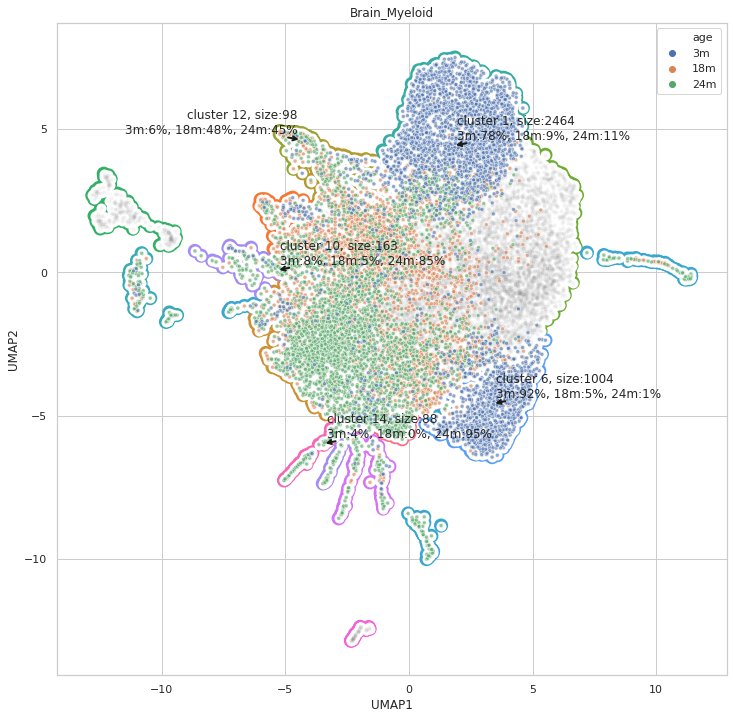

In [15]:
# UMAP plot
plt.figure(figsize=[12,12])
# Add cluster boundry
sns.scatterplot(x='UMAP1', y='UMAP2', data=df_UMAP, s=200, alpha=1,
                hue = 'leiden_str', legend=False, linewidth=0)
sns.scatterplot(x='UMAP1', y='UMAP2', data=df_UMAP, s=100, alpha=1, 
                legend=False, color='w', linewidth=0)
# All cells (background)
sns.scatterplot(x='UMAP1', y='UMAP2', data=df_UMAP, s=16, alpha=0.05, legend=False, color='k')
# Age-specific cells (from clusters in specific_cluster_list)
df_UMAP_age_specific = df_UMAP.loc[df_UMAP['leiden'].isin(specific_cluster_list)].copy()
sns.scatterplot(x='UMAP1', y='UMAP2', data=df_UMAP_age_specific, hue='age',
                hue_order=['3m', '18m', '24m'], s=16, alpha=0.6)
# Add annotation to clusters in annotation_cluster_list
annotation_cluster_list = ['1', '6', '10', '12', '14']
texts = []
for cluster_label in annotation_cluster_list:
    temp_ = df_UMAP.loc[df_UMAP['leiden']==cluster_label]
    label_str = 'cluster %s, size:%d\n'%(cluster_label, 
                                         df_cluster_annotation.loc[cluster_label,'cluster_size'])
    for age in age_list:
        label_str += '%s:%d%%, '\
            %(age, 100*df_cluster_annotation.loc[cluster_label,'%s.prop'%age])
    label_str = label_str[:-2]
    texts.append(plt.text(temp_['UMAP1'].median(), temp_['UMAP2'].median(),
                          label_str, fontsize=12))
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=2))
plt.title(analyte)
plt.show()